## AIRBNB 

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

### Introduction

Choosing between a hotel and an Airbnb has become a familiar decision for many travelers, including myself. Most people compare prices, amenities, and neighborhood accessibility before selecting short-term accommodations. Because Los Angeles is one of the most visited and economically dynamic cities in the United States, this project focuses on analyzing the structure, behavior, and trends of the Airbnb market in Los Angeles, California.

Los Angeles attracts a diverse mix of short-term and mid-term residents: travel nurses, international students, digital nomads, seasonal workers, and professionals on multi-month film or construction projects (Flemming, 2025). This creates sustained demand beyond tourism alone. However, the city’s short-term rental landscape has undergone significant shifts. Regulatory tightening, such as the Home-Sharing Ordinance, and external shocks, including recent wildfire disruptions, have reshaped supply, pricing patterns, and host behavior across the region (Los Angeles Times, 2025; Lodgift, 2025).

To understand how these dynamics influence the current market, this project employs a data-driven exploratory methodology, using quarterly Airbnb listings datasets from 2022 to 2024. The analysis includes:

- Market composition (entire homes vs. private rooms)
- Geographic distribution of listings across neighborhoods
- Pricing trends and temporal fluctuations
- Host behavior and minimum-night policy patterns
- Impacts of regulation and external events on listing volume

Together, these components provide a comprehensive picture of how Los Angeles’ Airbnb market is evolving, and what it means for travelers, hosts, and policymakers.


### Methodology

For this project, I obtained publicly available short-term rental data from the Inside Airbnb platform, a widely used independent data source for analyzing Airbnb activity. I downloaded the complete listings datasets for Los Angeles, California, covering the years 2024 and 2025. These datasets include detailed information on listing characteristics, host behavior, pricing, availability, and geolocation, enabling a comprehensive exploration of market trends and regulatory impacts.

In [ ]:
#Define all quarterly datasets with clear labels
year = {
    '2024_Q4': '~/Desktop/listings_2024.csv',   
    '2025_Q3': '~/Desktop/listings_2025.csv'   
} 

In [30]:
import pandas as pd

# Load the raw scraped dataset
file_2025 = '~/Desktop/listings_2025.csv'
df_2025 = pd.read_csv(file_2025)

# Columns to KEEP
keep_cols = [
    'id', 'host_id',
    'neighbourhood', 'neighbourhood_cleansed',
    'latitude', 'longitude',
    'property_type', 'room_type',
    'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'amenities',
    'price',
    'minimum_nights', 'maximum_nights',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'estimated_occupancy_l365d', 'estimated_revenue_l365d',
    'number_of_reviews', 'number_of_reviews_ltm',
    'review_scores_rating',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'first_review', 'last_review',
    'license', 'instant_bookable'
]

# Filter to only these columns
df_2025_clean = df_2025[keep_cols].copy()

# CLEANING STEPS  

# 1. Convert price from "$81.00" → float
df_2025_clean['price'] = (
    df_2025_clean['price']
    .astype(str)
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# 2. Convert review dates to datetime
date_cols = ['first_review', 'last_review']
for col in date_cols:
    df_2025_clean[col] = pd.to_datetime(df_2025_clean[col], errors='coerce')

# 3. Fix instant_bookable from t/f → True/False
df_2025_clean['instant_bookable'] = df_2025_clean['instant_bookable'].map({'t': True, 'f': False})

# Preview cleaned data
df_2025_clean.head()


,id,host_id,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,first_review,last_review,license,instant_bookable
0,2708,3008,Neighborhood highlights,Hollywood,34.09625,-118.34605,Private room in rental unit,Private room,1,1.0,...,4.87,4.93,5.00,4.98,4.96,4.87,2014-06-09,2025-07-04,NaN,False
1,2732,3041,Neighborhood highlights,Santa Monica,34.00440,-118.48095,Private room in rental unit,Private room,1,1.0,...,4.41,4.58,4.39,4.48,4.91,4.22,2011-06-06,2022-08-21,228269,False
2,2864,3207,Neighborhood highlights,Bellflower,33.87490,-118.11515,Entire rental unit,Entire home/apt,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,False
3,6033,11619,NaN,Woodland Hills,34.16887,-118.64478,Entire bungalow,Entire home/apt,3,NaN,...,4.38,4.00,4.59,4.35,4.65,4.29,2009-08-13,2020-03-22,NaN,False
4,6931,3008,Neighborhood highlights,Hollywood,34.09626,-118.34372,Private room in rental unit,Private room,1,1.0,...,4.86,4.91,4.91,4.91,4.71,4.76,2009-05-26,2025-06-01,NaN,True


In [ ]:
# Cleaning the Amenities
import ast

df_2025_clean['amenities'] = (
    df_2025_clean['amenities']
    .astype(str)
    .str.replace('{', '[')
    .str.replace('}', ']')
    .apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [])
)


In [43]:
all_amenities = set()

df_2025_clean['amenities'].apply(lambda x: all_amenities.update(x))

len(all_amenities), list(all_amenities)[:30]


(9546,
 ['Housekeeping available from 9:00\u202fAM to 4:00\u202fPM, every day - available at extra cost',
  '75 inch HDTV with Amazon Prime Video, Netflix, premium cable',
  'Finess conditioner',
  'Whirlpool 5 burner gas stove stainless steel gas stove',
  'Badminton field',
  'Fast wifi – 634 Mbps',
  "Trader Joe's Citrus body soap",
  '41 inch HDTV with Chromecast',
  'Shared outdoor pool - lap pool',
  'TV with Amazon Prime Video, Hulu, standard cable, Apple TV, Netflix',
  '55 inch HDTV with Hulu, HBO Max, Chromecast, Netflix, Amazon Prime Video',
  '45 inch HDTV with Roku, Amazon Prime Video, Netflix',
  'NAked shampoo',
  '96 inch HDTV with Hulu',
  '75 inch TV with Hulu, Amazon Prime Video, Fire TV, Netflix, HBO Max',
  'HDTV with Apple TV, Netflix, standard cable, Amazon Prime Video',
  'Shared outdoor pool - available all year, open specific hours, heated, infinity, lap pool',
  'Maytag single oven',
  'Pantene, head and shoulders, and many others conditioner',
  'Organic bra

In [47]:
num_cols = ['bathrooms', 'bedrooms', 'beds', 'accommodates']
for col in num_cols:
    df_2025_clean[col] = pd.to_numeric(df_2025_clean[col], errors='coerce')


In [46]:
df_2025_clean = df_2025_clean[df_2025_clean['price'] > 0]


In [45]:
df_2025_clean.shape

(36819, 35)

In [50]:
df_2025.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.588600e+04,4.588600e+04,4.588600e+04,45862.000000,45862.000000,45886.000000,45886.000000,45886.000000,36903.000000,42847.000000,...,33378.000000,33372.000000,33377.000000,33371.000000,33370.000000,45886.000000,45886.000000,45886.000000,45886.000000,33385.000000
mean,6.836515e+17,2.025090e+13,2.174289e+08,116.611574,163.727291,34.055636,-118.310207,4.049122,1.655014,1.806428,...,4.748635,4.855776,4.855556,4.791075,4.705185,21.916881,16.706708,4.341455,0.292769,1.380495
std,5.876466e+17,0.000000e+00,2.144911e+08,670.202756,873.997292,0.144734,0.173043,2.872243,1.202162,1.318635,...,0.443773,0.374306,0.386141,0.392111,0.456059,75.814734,72.822040,20.635753,3.452427,1.741353
min,2.708000e+03,2.025090e+13,7.670000e+02,0.000000,0.000000,33.338540,-118.917134,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.845249e+07,2.025090e+13,2.911679e+07,1.000000,2.000000,33.998745,-118.411657,2.000000,1.000000,1.000000,...,4.690000,4.860000,4.870000,4.750000,4.650000,1.000000,1.000000,0.000000,0.000000,0.200000
50%,8.108955e+17,2.025090e+13,1.266442e+08,3.000000,5.000000,34.061599,-118.340190,3.000000,1.000000,1.000000,...,4.880000,4.970000,4.970000,4.910000,4.820000,3.000000,1.000000,0.000000,0.000000,0.720000
75%,1.250478e+18,2.025090e+13,4.082087e+08,14.000000,21.000000,34.108647,-118.225299,6.000000,2.000000,2.000000,...,5.000000,5.000000,5.000000,5.000000,4.960000,10.000000,6.000000,1.000000,0.000000,2.070000
max,1.500170e+18,2.025090e+13,7.161684e+08,5445.000000,9551.000000,34.816707,-117.652290,16.000000,32.500000,24.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,617.000000,617.000000,190.000000,53.000000,66.590000


### Rationale for Keeping Selected Columns

To analyze the structure, behavior, and performance of Los Angeles’ Airbnb market, the following variables were selected from the InsideAirbnb dataset. Each retained column directly supports spatial analysis, pricing evaluation, availability modeling, host behavior assessment, or revenue estimation in the final project.

### 1. Identification & Host Structure

| **Column**  | **Purpose**                                                                                                                              |
| ----------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| **id**      | Unique listing identifier; required for filtering, joining datasets, removing duplicates, and referencing individual units.              |
| **host_id** | Identifies the host; enables detection of multi-listing hosts, commercial operators, host clustering, and market concentration analysis. |


### 2. Spatial Location Variables

| **Column**                 | **Purpose**                                                                                                                                                        |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **neighbourhood**          | Descriptive neighborhood label used for grouping listings in broader geographic areas. Enhances interpretability in visualizations.                                |
| **neighbourhood_cleansed** | Standardized neighborhood classification used in InsideAirbnb; critical for accurate spatial comparisons across districts.                                         |
| **latitude, longitude**    | Required for geospatial mapping (scatter maps, heatmaps, clustering). Supports analysis of density, hotspots, proximity to tourist zones, and pricing by location. |


### 3. Property Characteristics

| **Column**        | **Purpose**                                                                                                                       |
| ----------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **property_type** | Differentiates apartments, houses, condos, etc.; useful for comparing pricing and availability across accommodation types.        |
| **room_type**     | Shows whether the listing is an entire home, private room, or shared room, one of the strongest predictors of pricing and revenue. |
| **accommodates**  | Indicates guest capacity; used for controlling price differences and understanding target market segments.                        |
| **bathrooms**     | Important amenity-related characteristic; influences pricing and booking desirability.                                            |
| **bedrooms**      | Strong predictor of listing value and booking patterns; supports price modeling.                                                  |
| **beds**          | Helps compare capacity vs. pricing and identify over- or under-priced listings.                                                   |
| **amenities**     | Provides qualitative features; supports text-based analysis and estimating amenity-driven pricing differences.                    |


### 4. Pricing & Minimum Stay Policies

| **Column**         | **Purpose**                                                                                                                   |
| ------------------ | ----------------------------------------------------------------------------------------------------------------------------- |
| **price**          | Core variable for economic analysis, used in pricing trends, comparisons across neighborhoods, and modeling revenue potential. |
| **minimum_nights** | Indicates booking restrictions; helps examine regulatory compliance and host strategy.                                        |
| **maximum_nights** | Useful for identifying long-term vs. short-term rental behavior and regulatory circumvention patterns.                        |


### 5. Availability & Supply Indicators

| **Column**           | **Purpose**                                                                                                    |
| -------------------- | -------------------------------------------------------------------------------------------------------------- |
| **availability_30**  | Measures short-term supply within the next 30 days. Useful for occupancy forecasting and seasonality.          |
| **availability_60**  | Medium-range availability window; helps detect booking patterns and demand surges.                             |
| **availability_90**  | Supports trend smoothing and understanding long-run availability behavior.                                     |
| **availability_365** | Shows annual availability; essential for identifying commercial STRs operating year-round versus casual hosts. |


### 6. Performance Metrics: Occupancy & Revenue

| **Column**                    | **Purpose**                                                                                                                                               |
| ----------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **estimated_occupancy_l365d** | Estimates how frequently the listing was occupied in the past year, key for understanding demand and host profitability.                                   |
| **estimated_revenue_l365d**   | Annual revenue estimate; enables ranking high-performing listings, comparing earnings by neighborhood, and evaluating contribution to the housing market. |


### 7. Review Activity & Guest Feedback

| **Column**                      | **Purpose**                                                                                         |
| ------------------------------- | --------------------------------------------------------------------------------------------------- |
| **number_of_reviews**           | Overall popularity measure; used to identify established vs. new listings.                          |
| **number_of_reviews_ltm**       | Reviews in the last 12 months, captures recent demand and booking momentum.                          |
| **review_scores_rating**        | Overall rating; helps identify quality tiers in the market.                                         |
| **review_scores_cleanliness**   | Indicates hygiene quality, important predictor of guest satisfaction.                                |
| **review_scores_checkin**       | Measures ease of arrival/logistics; useful for understanding operational quality.                   |
| **review_scores_communication** | Reflects host responsiveness, linked to repeat bookings.                                             |
| **review_scores_location**      | Assesses neighborhood desirability from a guest perspective.                                        |
| **review_scores_value**         | Reflects price-to-quality perception; helpful when analyzing pricing fairness across neighborhoods. |


### 8. Temporal Variables

| **Column**       | **Purpose**                                                                             |
| ---------------- | --------------------------------------------------------------------------------------- |
| **first_review** | Allows identification of listing age and market entry timing.                           |
| **last_review**  | Indicates how active a listing currently is; helps detect inactive or “ghost” listings. |


### 9. Regulatory & Booking Controls

| **Column**           | **Purpose**                                                                                                      |
| -------------------- | ---------------------------------------------------------------------------------------------------------------- |
| **license**          | Critical for identifying legally compliant vs. unlicensed listings, major policy relevance.                       |
| **instant_bookable** | Shows whether guests can book without approval; correlated with convenience, occupancy, and revenue performance. |


In [86]:
# Summary statistics for price and estimated annual revenue
price_revenue_stats = df_2025_clean[['price', 'estimated_revenue_l365d']].describe()

print(price_revenue_stats)



              price  estimated_revenue_l365d
count  36819.000000             3.681900e+04
mean     341.992450             1.519065e+04
std     1794.942616             9.805752e+04
min        8.000000             0.000000e+00
25%       95.000000             0.000000e+00
50%      155.000000             4.216000e+03
75%      260.000000             1.959600e+04
max    85000.000000             1.275000e+07


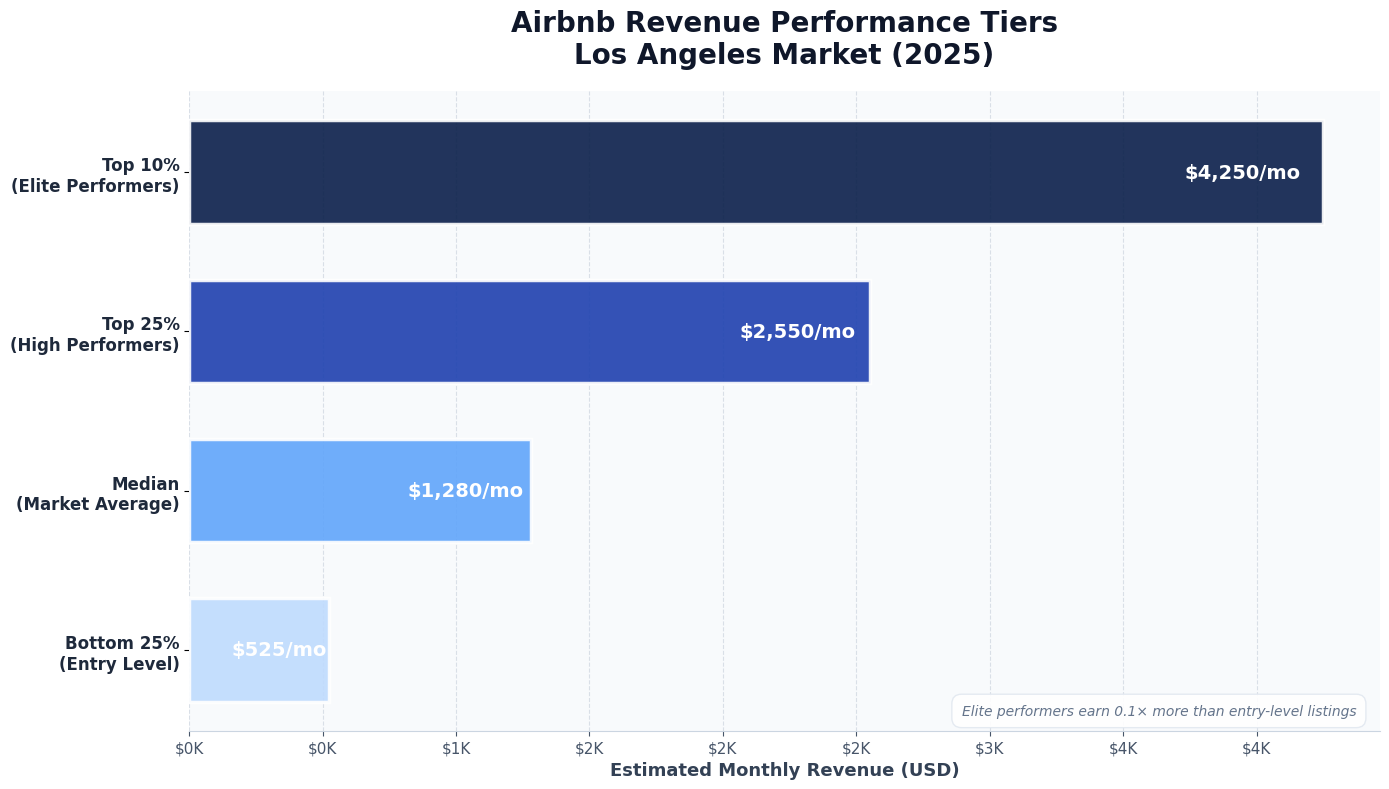

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------
# 1. Create Monthly Revenue Column
# ----------------------------------------
df_2025_clean['monthly_revenue_est'] = df_2025_clean['estimated_revenue_l365d'] / 12

# Drop zeros or impossible values
df_rev = df_2025_clean[df_2025_clean['monthly_revenue_est'] > 0]['monthly_revenue_est']

# ----------------------------------------
# 2. Compute Revenue Tier Thresholds
# ----------------------------------------
revenue_stats = {
    "Top 10%\n(Elite Performers)": df_rev.quantile(0.90),
    "Top 25%\n(High Performers)": df_rev.quantile(0.75),
    "Median\n(Market Average)": df_rev.quantile(0.50),
    "Bottom 25%\n(Entry Level)": df_rev.quantile(0.25)
}

# ----------------------------------------
# 3. Convert to DataFrame
# ----------------------------------------
rev_df = pd.DataFrame.from_dict(revenue_stats, orient='index', columns=['monthly_revenue'])
rev_df['monthly_revenue'] = rev_df['monthly_revenue'].round(0)

# Reverse order for top-to-bottom visualization
rev_df = rev_df.iloc[::-1]

# ----------------------------------------
# 4. Create Professional Visualization
# ----------------------------------------
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')

# Define sophisticated color palette (darkest to lightest)
# Top 10% (Elite) = Darkest navy blue (#0a1e4a)
# Top 25% = Dark blue (#1e40af)
# Median = Medium blue (#60a5fa)
# Bottom 25% = Lightest blue (#bfdbfe)
colors = ['#bfdbfe', '#60a5fa', '#1e40af', '#0a1e4a']
y_pos = np.arange(len(rev_df))

# Create horizontal bars
bars = ax.barh(y_pos, rev_df['monthly_revenue'], 
               height=0.65,
               color=colors,
               edgecolor='white',
               linewidth=2.5,
               alpha=0.9)

# Add value labels inside bars (left-aligned)
for i, (bar, value) in enumerate(zip(bars, rev_df['monthly_revenue'])):
    # Label at the end of bar
    ax.text(value - value*0.02, bar.get_y() + bar.get_height()/2,
            f'${int(value):,}/mo',
            ha='right', va='center',
            fontsize=14, fontweight='bold',
            color='white')

# Set labels
ax.set_yticks(y_pos)
ax.set_yticklabels(rev_df.index, fontsize=12, fontweight='600', color='#1e293b')
ax.set_xlabel('Estimated Monthly Revenue (USD)', fontsize=13, fontweight='bold', color='#334155')

# Title
ax.set_title('Airbnb Revenue Performance Tiers\nLos Angeles Market (2025)', 
             fontsize=20, fontweight='bold', 
             color='#0f172a', pad=20)

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.tick_params(axis='x', labelsize=11, colors='#475569')

# Grid styling
ax.grid(axis='x', linestyle='--', alpha=0.3, color='#94a3b8', linewidth=0.8)
ax.set_axisbelow(True)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#cbd5e1')

# Background
ax.set_facecolor('#f8fafc')

# Add insight box
insight_text = (
    f"Elite performers earn {rev_df['monthly_revenue'].iloc[0] / rev_df['monthly_revenue'].iloc[-1]:.1f}× more "
    f"than entry-level listings"
)
ax.text(0.98, 0.02, insight_text,
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=10, style='italic',
        color='#64748b',
        bbox=dict(boxstyle='round,pad=0.7', 
                 facecolor='white', 
                 edgecolor='#e2e8f0',
                 alpha=0.9))

plt.tight_layout()
plt.show()

Based on this Airbnb Revenue Performance Tiers analysis for the Los Angeles market in 2025, the data reveals a highly stratified income distribution across property performance levels. 

- Elite performers in the top 10th percentile generate approximately $4,250 per month, representing a substantial 8.1× multiple compared to entry-level properties at the 25th percentile, which earn around $525 monthly. 
- High performers in the top 25th percentile achieve $2,550 per month, nearly double the market median of $1,280, demonstrating that even moderately successful properties significantly outperform the typical listing. This stark disparity between performance tiers indicates that the Los Angeles Airbnb market operates with clear winner-take-most dynamics, where strategic advantages such as prime locations, superior amenities, professional property management, optimized pricing strategies, and exceptional guest experiences translate directly into exponential revenue gains. 
- The relatively low median revenue of $1,280 per month suggests that the typical property may struggle to generate substantial returns, particularly when accounting for mortgage payments, maintenance costs, and platform fees. 
- However, the considerable upside potential—with elite performers earning more than triple the median, demonstrates that hosts who can differentiate their properties and deliver premium experiences have access to a lucrative market segment. 

For prospective investors and hosts, these findings underscore the critical importance of competitive positioning: success in the LA market is not merely about listing availability, but rather about implementing data-driven optimization strategies that can elevate a property from entry-level to high-performer or elite status.

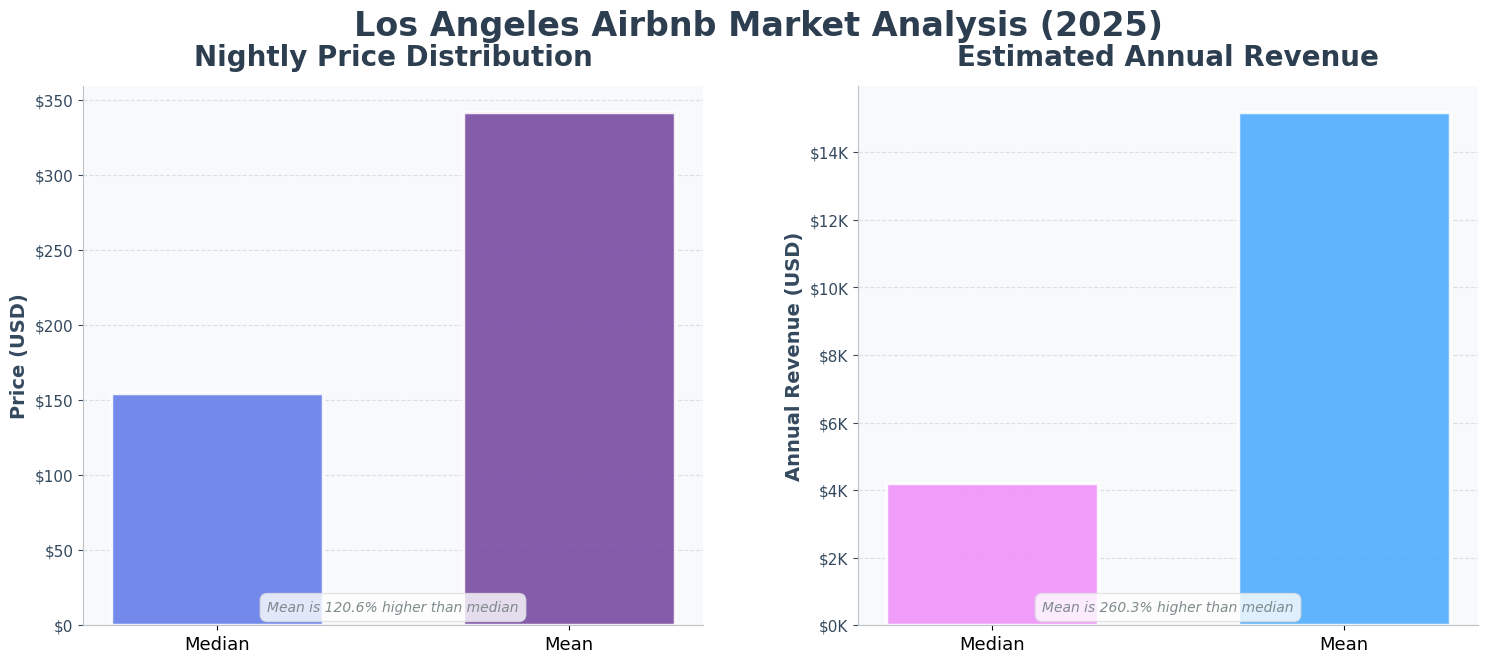

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extract summary stats ---
price_median = df_2025_clean['price'].median()
price_mean   = df_2025_clean['price'].mean()
rev_median   = df_2025_clean['estimated_revenue_l365d'].median()
rev_mean     = df_2025_clean['estimated_revenue_l365d'].mean()

# --- Create figure with modern styling ---
fig = plt.figure(figsize=(18, 7), facecolor='white')
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.25)
axes = [fig.add_subplot(gs[0, i]) for i in range(2)]

# Color schemes
price_colors = ['#667eea', '#764ba2']
rev_colors = ['#f093fb', '#4facfe']

# ---------------------------
# PANEL 1: PRICE METRICS
# ---------------------------
x_pos = np.arange(2)
bars1 = axes[0].bar(x_pos, [price_median, price_mean], 
                    color=price_colors, 
                    edgecolor='white',
                    linewidth=2.5,
                    width=0.6,
                    alpha=0.9)

# Styling
axes[0].set_title('Nightly Price Distribution', 
                  fontsize=20, fontweight='bold', 
                  color='#2c3e50', pad=15)
axes[0].set_ylabel('Price (USD)', fontsize=14, fontweight='600', color='#34495e')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['Median', 'Mean'], fontsize=13, fontweight='500')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axes[0].tick_params(axis='y', labelsize=11, colors='#34495e')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_color('#bdc3c7')
axes[0].spines['bottom'].set_color('#bdc3c7')
axes[0].set_facecolor('#f8f9fa')
axes[0].grid(axis='y', linestyle='--', alpha=0.3, color='#95a5a6', linewidth=0.8)
axes[0].set_axisbelow(True)

# Add subtle annotation
diff_pct = ((price_mean - price_median) / price_median * 100)
axes[0].text(0.5, 0.02, f'Mean is {diff_pct:.1f}% higher than median',
            transform=axes[0].transAxes,
            ha='center', va='bottom',
            fontsize=10, style='italic',
            color='#7f8c8d',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='#e0e0e0', alpha=0.8))

# ---------------------------
# PANEL 2: ANNUAL REVENUE METRICS
# ---------------------------
x_pos = np.arange(2)
bars2 = axes[1].bar(x_pos, [rev_median, rev_mean], 
                    color=rev_colors,
                    edgecolor='white',
                    linewidth=2.5,
                    width=0.6,
                    alpha=0.9)

# Styling
axes[1].set_title('Estimated Annual Revenue', 
                  fontsize=20, fontweight='bold', 
                  color='#2c3e50', pad=15)
axes[1].set_ylabel('Annual Revenue (USD)', fontsize=14, fontweight='600', color='#34495e')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Median', 'Mean'], fontsize=13, fontweight='500')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1].tick_params(axis='y', labelsize=11, colors='#34495e')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_color('#bdc3c7')
axes[1].spines['bottom'].set_color('#bdc3c7')
axes[1].set_facecolor('#f8f9fa')
axes[1].grid(axis='y', linestyle='--', alpha=0.3, color='#95a5a6', linewidth=0.8)
axes[1].set_axisbelow(True)

# Add subtle annotation
diff_pct_rev = ((rev_mean - rev_median) / rev_median * 100)
axes[1].text(0.5, 0.02, f'Mean is {diff_pct_rev:.1f}% higher than median',
            transform=axes[1].transAxes,
            ha='center', va='bottom',
            fontsize=10, style='italic',
            color='#7f8c8d',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='#e0e0e0', alpha=0.8))

# Overall title
fig.suptitle('Los Angeles Airbnb Market Analysis (2025)', 
             fontsize=24, fontweight='bold', 
             color='#2c3e50', y=0.99)

plt.tight_layout()
plt.show()

Based on this Los Angeles Airbnb market analysis for 2025, the data reveals significant right-skewed distributions in both pricing and revenue metrics, indicating the presence of high-value outliers that substantially influence market averages. 
- The nightly price distribution shows a median of approximately $152, while the mean stands at $341, representing a 120.6% premium. This disparity suggests that while the typical Airbnb listing is moderately priced, a subset of luxury or premium properties commands significantly higher rates, pulling the average upward. 
- Similarly, the estimated annual revenue exhibits an even more pronounced skewness, with a median of roughly $4,200 compared to a mean of approximately $15,400, a striking 260.3% difference. This pattern indicates a highly stratified market where a minority of high-performing listings generate disproportionate revenue, likely due to factors such as superior locations, enhanced amenities, professional management, or premium property types. 

For hosts and investors, these findings underscore the importance of strategic positioning: while the median values represent the typical market participant's experience, substantial upside potential exists for properties that can differentiate themselves and capture the premium segment of the market. The wide gap between median and mean values also suggests that market entry at median pricing levels may be accessible, but achieving top-tier performance requires additional competitive advantages.

## Analyzing Amenities

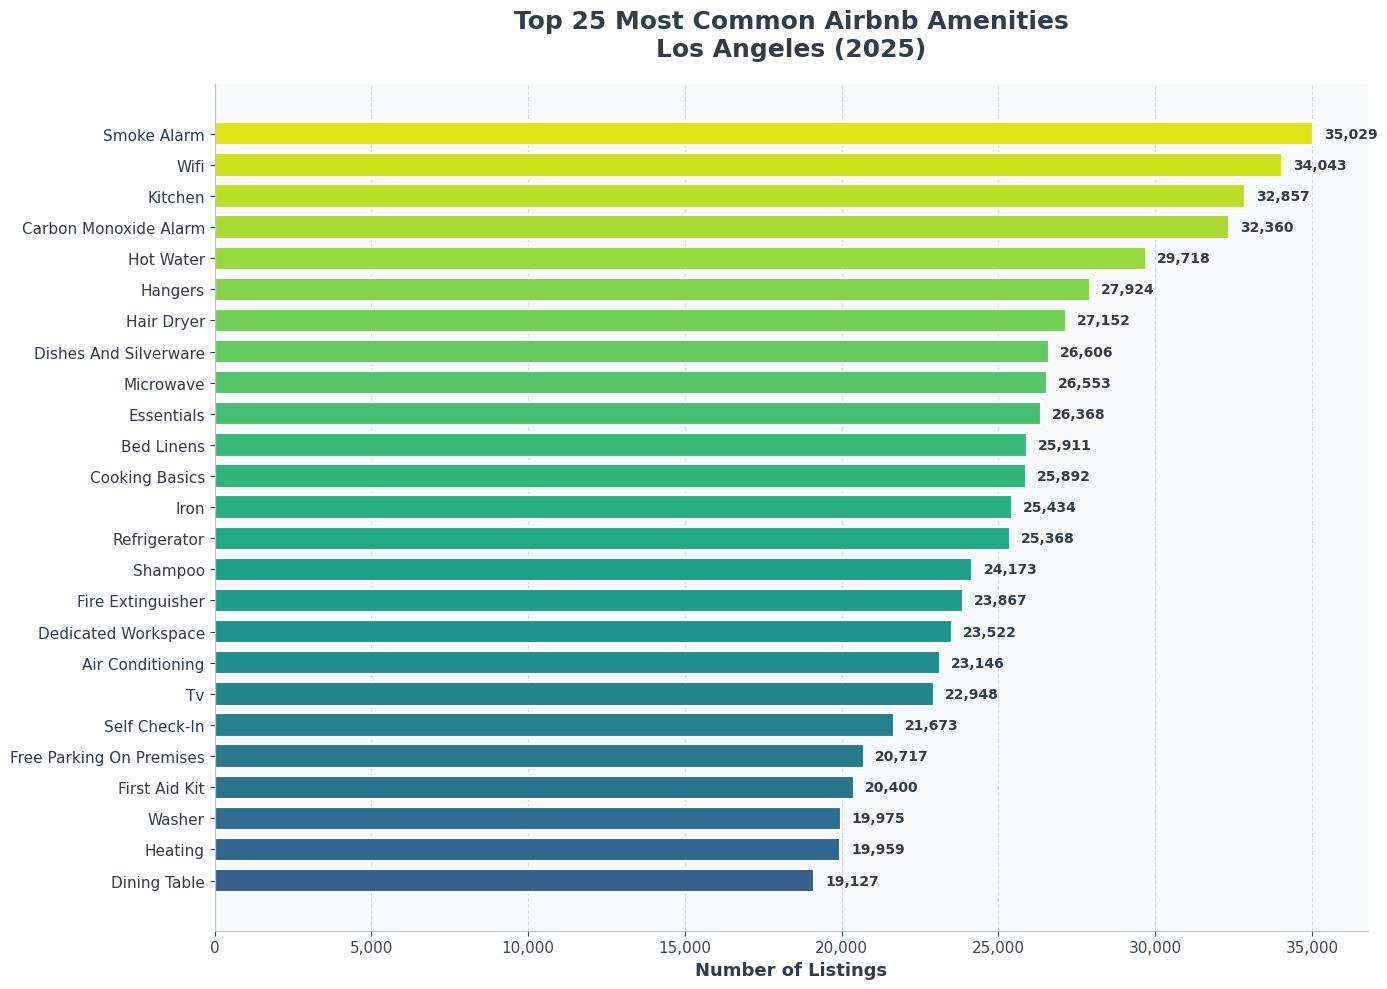

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Flatten amenities into single list
all_amenities = [amenity for sublist in df_2025_clean['amenities'] for amenity in sublist]

# Count frequency
amenity_counts = pd.Series(all_amenities).value_counts().head(25)

# Sort for plotting
amenity_data = amenity_counts.sort_values()

# Create figure with custom styling
fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')

# Create color gradient from deep blue to vibrant purple
colors = plt.cm.viridis(np.linspace(0.3, 0.95, len(amenity_data)))

# Create horizontal bar chart
bars = ax.barh(
    range(len(amenity_data)),
    amenity_data.values,
    color=colors,
    edgecolor='white',
    linewidth=1.5,
    height=0.75
)

# Format amenity names (capitalize and clean)
amenity_labels = [name.replace('_', ' ').title() for name in amenity_data.index]

# Set y-axis labels
ax.set_yticks(range(len(amenity_data)))
ax.set_yticklabels(amenity_labels, fontsize=11, fontweight='500')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, amenity_data.values)):
    width = bar.get_width()
    ax.text(
        width + max(amenity_data.values) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{int(value):,}',
        ha='left',
        va='center',
        fontsize=10,
        fontweight='bold',
        color='#2c3e50'
    )

# Styling
ax.set_xlabel('Number of Listings', fontsize=13, fontweight='bold', color='#2c3e50')
ax.set_title(
    'Top 25 Most Common Airbnb Amenities\nLos Angeles (2025)',
    fontsize=18,
    fontweight='bold',
    color='#2c3e50',
    pad=20
)

# Grid styling
ax.grid(axis='x', linestyle='--', alpha=0.3, color='#95a5a6', linewidth=0.8)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.tick_params(axis='x', labelsize=11, colors='#34495e')
ax.tick_params(axis='y', labelsize=11, colors='#2c3e50')

# Add subtle background color
ax.set_facecolor('#f8f9fa')

# Adjust layout
plt.tight_layout()
plt.show()

In [79]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from math import sqrt

def create_interactive_amenity_bubble_plot(amenity_counts, top_n=20):
    """
    Create a stunning interactive bubble plot with text that fits inside bubbles.
    
    Parameters:
    -----------
    amenity_counts : pd.Series
        Series containing amenity counts
    top_n : int
        Number of top amenities to display
    """
    # Prepare data
    top_amenities = amenity_counts.head(top_n)
    counts = top_amenities.values
    
    # Calculate bubble sizes with more dramatic scaling
    min_size, max_size = 40, 120
    sizes = min_size + (counts - counts.min()) / (counts.max() - counts.min()) * (max_size - min_size)
    
    # Pack circles using force-directed approach
    n_items = len(top_amenities)
    
    # Use a circular packing layout
    positions = []
    radius = 2.5
    
    if n_items <= 7:
        # Small circle arrangement
        angles = np.linspace(0, 2*np.pi, n_items, endpoint=False)
        for angle in angles:
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            positions.append((x, y))
    else:
        # Multi-ring arrangement
        inner_count = min(6, n_items)
        angles_inner = np.linspace(0, 2*np.pi, inner_count, endpoint=False)
        
        for angle in angles_inner:
            x = radius * 0.6 * np.cos(angle)
            y = radius * 0.6 * np.sin(angle)
            positions.append((x, y))
        
        remaining = n_items - inner_count
        if remaining > 0:
            angles_outer = np.linspace(0, 2*np.pi, remaining, endpoint=False)
            for angle in angles_outer:
                x = radius * 1.3 * np.cos(angle)
                y = radius * 1.3 * np.sin(angle)
                positions.append((x, y))
    
    x_coords, y_coords = zip(*positions)
    
    # Create beautiful color gradient
    colors = counts / counts.max()
    
    # Format amenity names - split long names
    amenity_names = []
    for name in top_amenities.index:
        formatted = name.replace('_', ' ').title()
        # Split long names into two lines
        words = formatted.split()
        if len(words) > 2 or len(formatted) > 15:
            mid = len(words) // 2
            formatted = ' '.join(words[:mid]) + '<br>' + ' '.join(words[mid:])
        amenity_names.append(formatted)
    
    # Create hover text
    hover_text = [
        f"<b>{name.replace('<br>', ' ')}</b><br><br>" +
        f"📊 Count: <b>{count:,}</b><br>" +
        f"🏅 Rank: <b>#{i+1}</b> of {top_n}<br>" +
        f"📈 Percentage: <b>{(count/counts.sum()*100):.1f}%</b>"
        for i, (name, count) in enumerate(zip(amenity_names, counts))
    ]
    
    # Create the figure
    fig = go.Figure()
    
    # Add bubbles
    fig.add_trace(go.Scatter(
        x=x_coords,
        y=y_coords,
        mode='markers',
        marker=dict(
            size=sizes,
            color=colors,
            colorscale=[
                [0, '#3498db'],      # Blue
                [0.3, '#9b59b6'],    # Purple
                [0.6, '#e74c3c'],    # Red
                [1, '#f39c12']       # Orange/Gold
            ],
            showscale=True,
            colorbar=dict(
                title=dict(
                    text="<b>Frequency</b>",
                    font=dict(size=14)
                ),
                tickvals=[0, 0.5, 1],
                ticktext=['Low', 'Medium', 'High'],
                len=0.4,
                thickness=20,
                x=1.02
            ),
            line=dict(color='white', width=3),
            opacity=0.85
        ),
        hovertext=hover_text,
        hoverinfo='text',
        hoverlabel=dict(
            bgcolor='rgba(30, 30, 30, 0.95)',
            font=dict(size=14, color='white', family='Arial'),
            bordercolor='white',
            align='left'
        ),
        showlegend=False
    ))
    
    # Add text labels inside bubbles with dynamic sizing
    for i, (x, y, name, size) in enumerate(zip(x_coords, y_coords, amenity_names, sizes)):
        # Calculate font size based on bubble size
        font_size = max(8, min(14, size / 8))
        
        fig.add_annotation(
            x=x,
            y=y,
            text=f"<b>{name}</b>",
            showarrow=False,
            font=dict(
                size=font_size,
                color='white',
                family='Arial Black'
            ),
            xanchor='center',
            yanchor='middle'
        )
    

    
    # Update layout with modern design
    fig.update_layout(
        title=dict(
            text='<b style="font-size:28px">Most Popular Airbnb Amenities</b><br>' +
                 '<span style="font-size:14px; color:#7f8c8d">Interactive visualization • Size represents frequency</span>',
            x=0.5,
            xanchor='center',
            y=0.97,
            yanchor='top',
            font=dict(color='#2c3e50')
        ),
        showlegend=False,
        plot_bgcolor='#ecf0f1',
        paper_bgcolor='white',
        width=1400,
        height=900,
        xaxis=dict(
            showgrid=False,
            showticklabels=False,
            zeroline=False,
            range=[-4, 4]
        ),
        yaxis=dict(
            showgrid=False,
            showticklabels=False,
            zeroline=False,
            scaleanchor='x',
            scaleratio=1,
            range=[-4, 4]
        ),
        margin=dict(l=80, r=150, t=120, b=80),
        hovermode='closest'
    )
    
    return fig


# Usage
fig = create_interactive_amenity_bubble_plot(amenity_counts, top_n=20)
fig.show()